In [ ]:
import feature_engineering.preprocessing
import LSTM.model

import datetime
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

### MULTIVARIATE TIME SERIES - INPUT 5 FEATURES, PREDICT CLOSE PRICE

In [ ]:
from keras.layers import LSTM, Dense, Flatten
import tensorflow as tf
from keras.models import Sequential
model2 = Sequential()

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 256
num_neurons_L2 = 256
num_neurons_dense1 = 1

num_features = 5
lookback = 50 #How many days of the past can the model see
horizon = 1 
learning_rate = 1e-3

model2.add(LSTM(units = num_neurons_L1, input_shape=(lookback,num_features), return_sequences=True, activation = 'relu', dropout=0.3))
model2.add(LSTM(num_neurons_L2, activation = 'relu', dropout=0.3, return_sequences=False))
model2.add(Flatten())
model2.add(Dense(horizon, activation = 'sigmoid'))

model2.compile(loss='Huber', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mean_absolute_error'])

In [ ]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50, 256)           268288    
                                                                 
 lstm_19 (LSTM)              (None, 256)               525312    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 793857 (3.03 MB)
Trainable params: 793857 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_budimex, test_budimex = feature_engineering.preprocessing.load_train_test_data_from_tickers(
    'BDX.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Open', 'High', 'Low', 'Close', 'Volume'],
    scale=True, test_size=0.2)

In [ ]:
train_budimex.shape

(1031, 5)

In [ ]:
X_train_budimex = feature_engineering.preprocessing.adjust_X_train_data(train_budimex, 50)
Y_train_budimex = train_budimex[50:]['Close']
X_test_budimex = feature_engineering.preprocessing.adjust_X_train_data(test_budimex, 50)
Y_test_budimex = test_budimex[50:]['Close']

In [ ]:
X_train_budimex.shape

(981, 50, 5)

In [ ]:
fit_model2 = model2.fit(X_train_budimex, Y_train_budimex, epochs=3,
                    batch_size= 64,
                    shuffle=False, verbose=2)

Epoch 1/3


16/16 - 6s - loss: 0.0191 - mean_absolute_error: 0.1540 - 6s/epoch - 369ms/step
Epoch 2/3
16/16 - 6s - loss: 0.0191 - mean_absolute_error: 0.1540 - 6s/epoch - 359ms/step
Epoch 3/3
16/16 - 6s - loss: 0.0191 - mean_absolute_error: 0.1539 - 6s/epoch - 360ms/step


In [ ]:
# serialize model to JSON
model2_json = model2.to_json()
with open("budimex_model2.json", "w") as json_file:
    json_file.write(model2_json)
# serialize weights to HDF5
model2.save_weights("budimex_model2.h5")
print("Saved model2 to disk")

Saved model2 to disk


In [ ]:
train_predict = model2.predict(X_train_budimex)
test_predict = model2.predict(X_test_budimex)

7/7 [==============================] - 1s 123ms/step


In [ ]:
train_predict.shape

(981, 1)

In [ ]:
budimex_close_data = feature_engineering.preprocessing.get_data_by_ticker('BDX.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
invert_data = feature_engineering.preprocessing.inverse_scaling_data(budimex_close_data, train_predict)
invert_test_data = feature_engineering.preprocessing.inverse_scaling_data(budimex_close_data, test_predict)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(budimex_close_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[51:(len(train_budimex)+1), :]= invert_data

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(budimex_close_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_budimex)+1:len(budimex_close_data)-50+1, :]= invert_test_data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


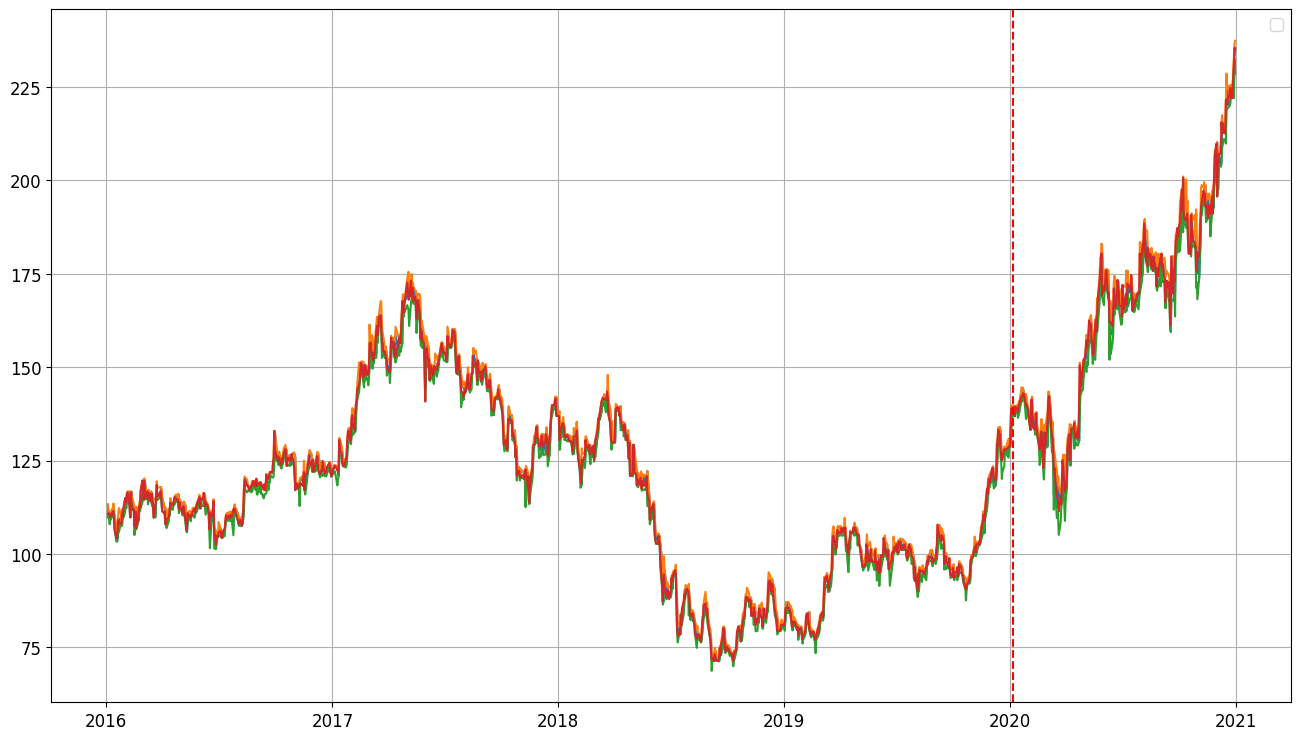

In [ ]:
budimex_all_features_data = feature_engineering.preprocessing.get_data_by_ticker('BDX.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Open', 'High', 'Low', 'Close'])
# plot baseline and predictions
plt.plot(budimex_all_features_data)
plt.axvline(x=budimex_close_data.index[len(train_budimex)], c='r', linestyle='--')
plt.legend()
plt.show()

In [ ]:
budimex_all_features_data

,Open,High,Low,Close
Date,,,,
2016-01-04 00:00:00+01:00,113.245629,113.245629,109.801564,110.618797
2016-01-05 00:00:00+01:00,110.239385,112.019786,110.239385,110.910683
2016-01-07 00:00:00+01:00,109.743199,110.910680,107.991978,110.852303
2016-01-08 00:00:00+01:00,109.159440,110.910661,109.159440,109.918304
2016-01-11 00:00:00+01:00,110.852305,112.048975,110.035072,110.910683
...,...,...,...,...
2020-12-24 00:00:00+01:00,222.069656,222.069656,222.069656,222.069656
2020-12-25 00:00:00+01:00,222.069656,222.069656,222.069656,222.069656
2020-12-28 00:00:00+01:00,222.069662,233.154034,222.069662,231.242935


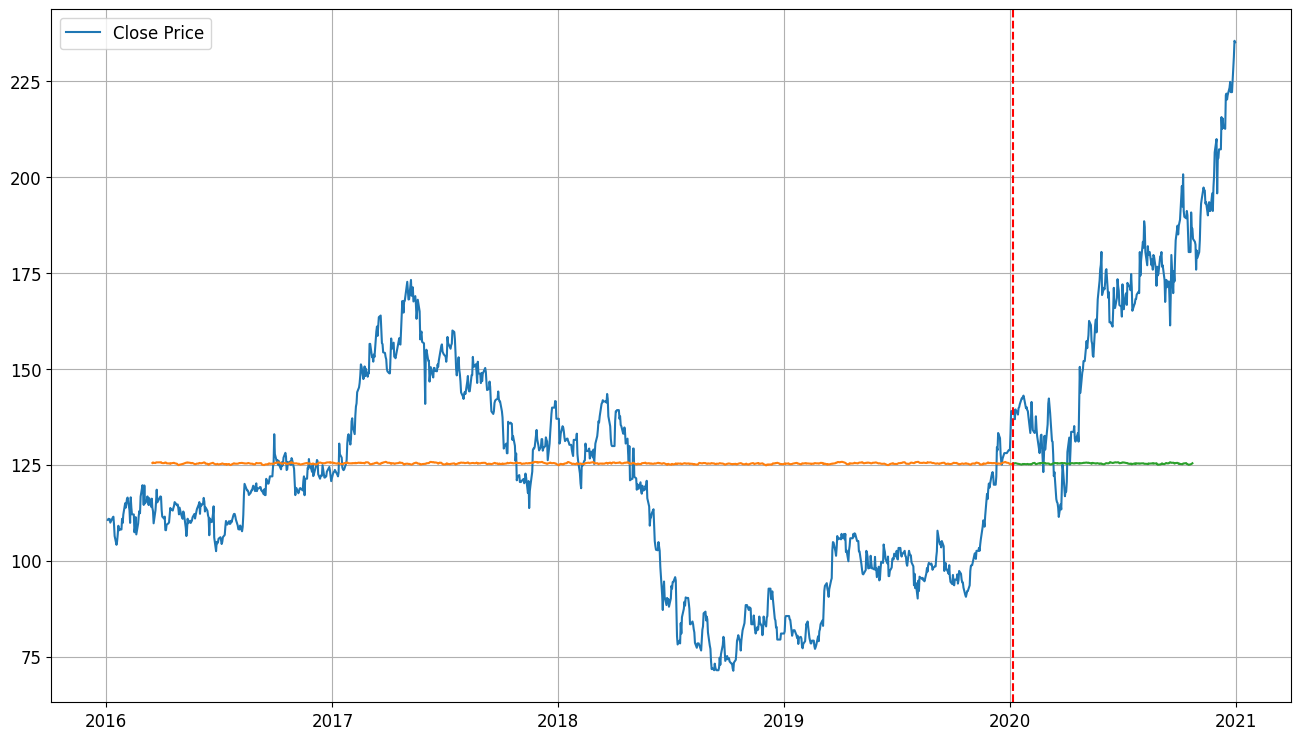

In [ ]:
# plot baseline and predictions
plt.plot(budimex_close_data, label='Close Price')
plt.plot(budimex_close_data.index, trainPredictPlot)
plt.plot(budimex_close_data.index, testPredictPlot)
plt.axvline(x=budimex_close_data.index[len(train_budimex)], c='r', linestyle='--')
plt.legend()
plt.show()

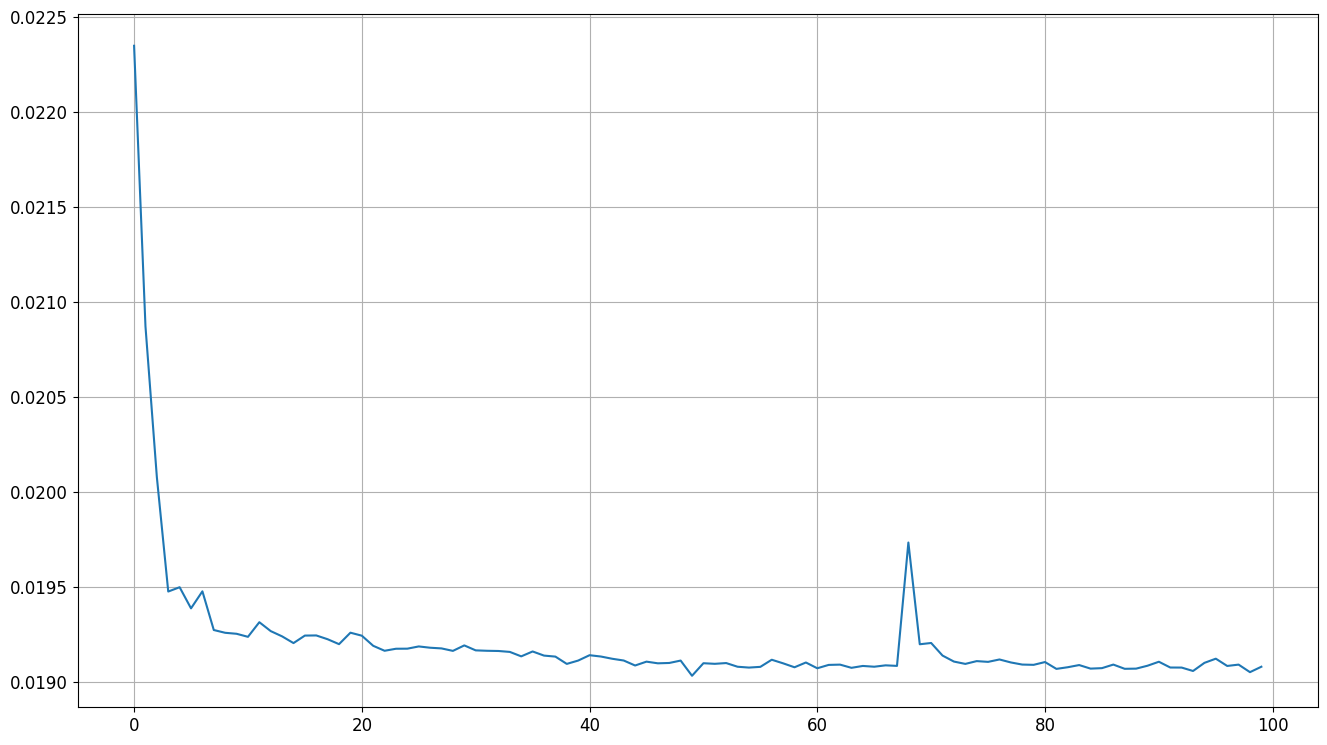

In [ ]:
plt.plot(np.arange(0, 100), fit_model2.history['loss'])